# Predict model Day Ahead France Energy Price

In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

pd.options.display.max_rows = 10
pd.options.display.max_columns = None

In [2]:
dataset = pd.read_pickle('data/dataset_eda.pkl.zip', compression='zip')

Change dataset granularity to daily

In [3]:
dataset = dataset.resample('d').mean().dropna()
dataset.shape

(1441, 132)

In [5]:
X = dataset.drop(['Y'],1).astype(np.float64)
y = dataset['Y']

### Machine Learning Models 
 - Ridge, Lasso, ElasticNet
 - KNeighbors
 - RandomForest, ExtraTrees, AdaBoost
 - SVR
 - Xgboost, LightGBM
 - MLP

In [7]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def smape(y_true, y_pred):
    out = 0
    for i in range(y_true.shape[0]):
        a = y_true[i]
        b = y_pred[i]
        c = abs(a)+abs(b)
        if c == 0:
            continue
        out += abs(a - b) / c
    out *= (100.0 / y_true.shape[0])
    return out

In [8]:
def eval_model(model, cv, X, y):
    predictions = pd.DataFrame(index = X.index, columns=['true','train_pred','test_pred'])
    predictions['true'] = y
    X, y = X.values, y.values
    for train_idx, test_idx in cv.split(X, y):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]

        X_scaler = MinMaxScaler(feature_range=(-1,1))
        X_train = X_scaler.fit_transform(X_train)
        X_test = X_scaler.transform(X_test)

        y_scaler = MinMaxScaler(feature_range=(-1,1))
        y_train = y_scaler.fit_transform(y_train.reshape(-1,1))
        y_test = y_scaler.transform(y_test.reshape(-1,1))
        
        model.fit(X_train, y_train.ravel())
        
        predictions.iloc[train_idx, 1] = y_scaler.inverse_transform(model.predict(X_train).reshape(-1,1))
        predictions.iloc[test_idx, 2] = y_scaler.inverse_transform(model.predict(X_test).reshape(-1,1))

    return predictions.astype(np.float64)

In [10]:
def eval_predictions(predictions, view=True):
    df_train = predictions[['true','train_pred']].copy().dropna()
    df_test = predictions[['true','test_pred']].copy().dropna()
    print(f"R2 Score Train:  {r2_score(df_train['true'], df_train['train_pred']):.3f}")
    print(f"R2 Score Test:   {r2_score(df_test['true'], df_test['test_pred']):.3f}")
    print(f"RMSE Train:      {np.sqrt(mean_squared_error(df_train['true'], df_train['train_pred'])):.3f}")
    print(f"RMSE Test:       {np.sqrt(mean_squared_error(df_test['true'], df_test['test_pred'])):.3f}")
    print(f"MAE Train:       {mean_absolute_error(df_train['true'], df_train['train_pred']):.3f}")
    print(f"MAE Test:        {mean_absolute_error(df_test['true'], df_test['test_pred']):.3f}")
    print(f"sMAPE Train:     {smape(df_train['true'], df_train['train_pred']):.3f}")
    print(f"sMAPE Test:      {smape(df_test['true'], df_test['test_pred']):.3f}")
    
    if view:
        fig, ax = plt.subplots(1,2,figsize=(10,3))
        ax[0].hist(df_train['true']-df_train['train_pred'], bins=50, alpha=.4, edgecolor='black',label='train')
        ax[0].hist(df_test['true']-df_test['test_pred'], bins=50, alpha=.4, edgecolor='black',label='test')
        ax[0].set_title('Residuals distribution')
        ax[0].set_xlabel('Residuals')
        ax[0].set_ylabel('Distribution')
        ax[0].legend()
          
        sns.regplot(df_train['true'], df_train['train_pred'], label='train reg', 
                    scatter_kws={'alpha':.8, 'edgecolor':'white'}, 
                    line_kws={'alpha':.5, 'color':'red'}, ax=ax[1])
        sns.regplot(df_test['true'], df_test['test_pred'], label='test reg', 
                    scatter_kws={'alpha':.8, 'edgecolor':'white'}, 
                    line_kws={'alpha':.5, 'color':'red'}, ax=ax[1])
        ax[1].set_title('Regression Plot')
        ax[1].set_xlabel('True')
        ax[1].set_ylabel('Prediction')
        ax[1].legend()
        plt.show()
    return

In [14]:
model0 = ('LinearRegression', LinearRegression(n_jobs=-1))
model1 = ('Ridge', Ridge(random_state=33))
model2 = ('Lasso', Lasso(random_state=33))
model3 = ('ElasticNet', ElasticNet(random_state=33))
model4 = ('KNeighbors', KNeighborsRegressor(n_jobs=-1))
model5 = ('RandomForest', RandomForestRegressor(n_jobs=-1, random_state=33))
model6 = ('ExtraTrees', ExtraTreesRegressor(n_jobs=-1, random_state=33))
model7 = ('AdaBoost', AdaBoostRegressor(random_state=33))
model8 = ('GradientBoost', GradientBoostingRegressor(random_state=33))
model9 = ('SVR', SVR())
model10 = ('XGBoost', XGBRegressor(n_jobs=-1, random_state=33))
model11 = ('LightGBM', LGBMRegressor(n_jobs=-1, random_state=33))
model12 = ('MLP', MLPRegressor(random_state=33))

models = [model0, model1, model2, model3, model4, model5, model6, model7, 
          model8, model9, model10, model11, model12]

tscv = TimeSeriesSplit(n_splits=5)
scaler = MinMaxScaler(feature_range=(-1,1))

for i, model in tqdm_notebook(enumerate(models), total=len(models)):
    print(f"MODEL: {model[0]}")
    predictions = eval_model(model[1], tscv, X, y)[['true','test_pred']].dropna()
    print(f" - test mae: {mean_absolute_error(predictions['true'], predictions['test_pred']):.2f}")
    print(f" - test smape: {smape(predictions['true'], predictions['test_pred'])}")

MODEL: LinearRegression
 - test mae: 4.93
 - test smape: 6.853272537886068
MODEL: Ridge
 - test mae: 5.18
 - test smape: 7.071979553730083
MODEL: Lasso
 - test mae: 12.56
 - test smape: 14.765379993720295
MODEL: ElasticNet
 - test mae: 12.56
 - test smape: 14.765379993720295
MODEL: KNeighbors
 - test mae: 11.27
 - test smape: 13.696127569169791
MODEL: RandomForest
 - test mae: 6.61
 - test smape: 8.16477061977442
MODEL: ExtraTrees
 - test mae: 6.89
 - test smape: 8.423953430738026
MODEL: AdaBoost
 - test mae: 6.80
 - test smape: 8.330498415428467
MODEL: GradientBoost
 - test mae: 5.76
 - test smape: 7.131328736457927
MODEL: SVR
 - test mae: 7.24
 - test smape: 9.01706287381304
MODEL: XGBoost
 - test mae: 5.77
 - test smape: 7.197496137735273
MODEL: LightGBM
 - test mae: 6.06
 - test smape: 7.500362237159504
MODEL: MLP
 - test mae: 8.17
 - test smape: 10.734589212751771


It seems that linear models performs better, let's try to optimize some hyperparameters for Ridge, Lasso, ElasticNet and MLP.

To do this we are going to use hyperopt library for bayesian search.

In [16]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval, STATUS_FAIL
from hyperopt.pyll.base import scope

tscv = TimeSeriesSplit(n_splits=5)

spaces = {
    'ridge': {
         'regressor': 'ridge',
         'alpha': hp.qloguniform('alpha', np.log(1e-8), np.log(10), 1e-7)
     },
    'lasso': {
        'regressor': 'lasso',
        'alpha': hp.qloguniform('alpha', np.log(1e-8), np.log(10), 1e-7),
        'max_iter': scope.int(hp.quniform('max_iter', 1000, 5000, 500))
    },
    'elasticnet': {
        'regressor': 'elasticnet',
        'alpha': hp.qloguniform('alpha', np.log(1e-8), np.log(10), 1e-7),
        'l1_ratio': hp.qloguniform('l1_ratio', np.log(1e-5), np.log(10), 1e-4),
        'max_iter': scope.int(hp.quniform('max_iter', 1000, 5000, 500))
    },
    'mlp': {
        'regressor': 'mlp',
        'hidden_layer_sizes': scope.int(hp.quniform('hidden_layer_sizes', 10, 500, 10)),
        'activation': hp.choice('activation', ['identity', 'logistic', 'tanh', 'relu']),
        'solver': hp.choice('solver', ['lbfgs', 'sgd', 'adam']),
        'alpha': hp.qloguniform('alpha', np.log(1e-7), np.log(10), 1e-6),
        'momentum': hp.quniform('momentum', 0.1, 0.9, 0.1)
    }
}

# Objective Function to minimize
def f_objective(p):
    try:
        t = p['regressor']
        del p['regressor']
        if t == 'ridge':
            model = Ridge(random_state=33, **p)
        elif t == 'lasso':
            model = Lasso(random_state=33, **p)
        elif t == 'elasticnet':
            model = ElasticNet(random_state=33, **p)
        elif t == 'mlp':
            model = MLPRegressor(random_state=33, early_stopping=True, **p)

        predictions = eval_model(model=model, cv=tscv, X=X, y=y)[['true','test_pred']].dropna()
        loss = mean_absolute_error(predictions['true'], predictions['test_pred'])

        return { 'loss': loss, 'status': STATUS_OK }
    except Exception as e:
        #print(f"Error: {e}")
        return { 'loss': np.Inf, 'status': STATUS_FAIL }
    
for model, space in spaces.items():
    print(model.upper())
    best = fmin(fn=f_objective,
                space=space, 
                algo=tpe.suggest,
                max_evals=100,
                show_progressbar=True,
                trials=Trials())
    # best hyperparameters
    print("The best hyperparameters:")
    print(space_eval(space, best))

RIDGE
100%|██████████| 100/100 [00:07<00:00, 13.05it/s, best loss: 4.93391550868278]
The best hyperparameters:
{'alpha': 1e-07, 'regressor': 'ridge'}
LASSO
100%|██████████| 100/100 [01:12<00:00,  1.21it/s, best loss: 4.913662486798732]
The best hyperparameters:
{'alpha': 0.0, 'max_iter': 1000, 'regressor': 'lasso'}
ELASTICNET
100%|██████████| 100/100 [01:34<00:00,  1.05s/it, best loss: 4.913662486798732]
The best hyperparameters:
{'alpha': 0.0, 'l1_ratio': 0.0001, 'max_iter': 1000, 'regressor': 'elasticnet'}
MLP
100%|██████████| 100/100 [12:36<00:00,  7.42s/it, best loss: 4.542979526318773]
The best hyperparameters:
{'activation': 'identity', 'alpha': 0.000214, 'hidden_layer_sizes': 140, 'momentum': 0.7000000000000001, 'regressor': 'mlp', 'solver': 'lbfgs'}


R2 Score Train:  0.923
R2 Score Test:   0.867
RMSE Train:      4.081
RMSE Test:       5.968
MAE Train:       3.076
MAE Test:        4.543
sMAPE Train:     4.216
sMAPE Test:      6.196


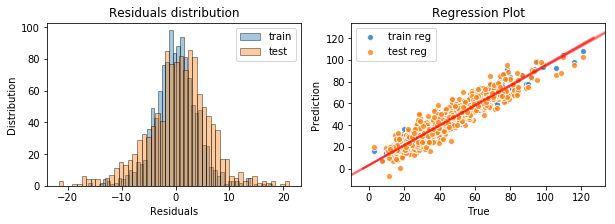

In [18]:
best_mlp = {'activation': 'identity', 'alpha': 0.000214, 'hidden_layer_sizes': 140, 
            'momentum': 0.7, 'solver': 'lbfgs'}

model = MLPRegressor(random_state=33, early_stopping=True, **best_mlp)
predictions = eval_model(model, tscv, X, y)
eval_predictions(predictions)

We reached the best MAE on test data __(4.54€)__ with a MLP.

We used all the dataset to build machine learning models (I tried PCA before but didn't help), we can try to reduce the dimensionality with some feature selection approaches and see what happends.

I decided to test the performances only for one model: XGBoost

### XGBoost feature selection

#### 1. RFECV

Fitting estimator with 131 features.
Fitting estimator with 130 features.
Fitting estimator with 129 features.
Fitting estimator with 128 features.
Fitting estimator with 127 features.
Fitting estimator with 126 features.
Fitting estimator with 125 features.
Fitting estimator with 124 features.
Fitting estimator with 123 features.
Fitting estimator with 122 features.
Fitting estimator with 121 features.
Fitting estimator with 120 features.
Fitting estimator with 119 features.
Fitting estimator with 118 features.
Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
F

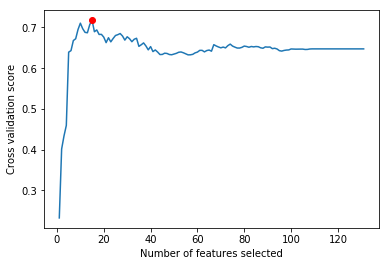

In [20]:
from sklearn.feature_selection import RFECV

regressor = XGBRegressor(n_jobs=-1, random_state=33)
tscv = TimeSeriesSplit(n_splits=5)
rfecv = RFECV(estimator=regressor, cv=tscv, verbose=1, n_jobs=-1)
rfecv.fit(X, y)

print(f'Optimal number of features : {rfecv.n_features_}')
features = list(X.columns[rfecv.get_support()])
print(features)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.plot(rfecv.n_features_, max(rfecv.grid_scores_), 'ro')
plt.show()

X_rfe = pd.DataFrame(rfecv.transform(X), index=X.index, columns=features)

R2 Score Train:  0.947
R2 Score Test:   0.802
RMSE Train:      3.380
RMSE Test:       7.266
MAE Train:       2.569
MAE Test:        5.085
sMAPE Train:     3.583
sMAPE Test:      6.313


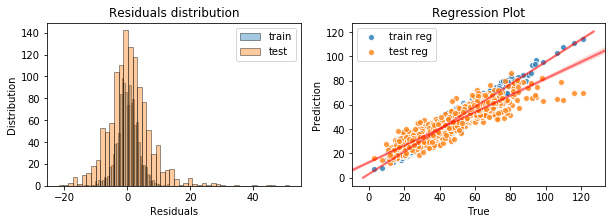

In [21]:
regressor = XGBRegressor(n_jobs=-1, random_state=33)
predictions = eval_model(model=regressor, cv=tscv, X=X_rfe, y=y)
eval_predictions(predictions)

We reduced a bit the error, but we still have some overfitting.

#### 2. SFM

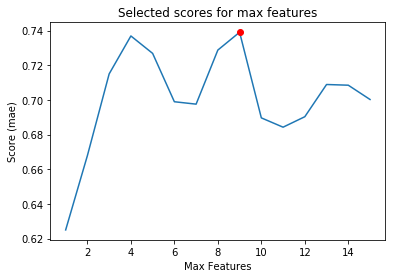

In [25]:
from sklearn.feature_selection import SelectFromModel

regressor = XGBRegressor(n_jobs=-1, random_state=33)
sfm = SelectFromModel(estimator=regressor, max_features=X.shape[1])
X_sfm = sfm.fit_transform(X, y)
min_err, max_features, X_best, best_support = -np.Inf, -1, X_sfm, sfm.get_support()
scores, n_features = [], []
for n in tqdm_notebook(range(X_sfm.shape[1], 0, -1)):
    sfm.max_features = n
    X_sfm = sfm.transform(X)
    score = np.mean(np.abs(cross_val_score(regressor, X_sfm, y, cv=tscv)))
    scores.append(score)
    n_features.append(n)
    if score < min_err:
        print(f'max_features: {n}, best score: {score}')
        min_err = score
        max_features=n
        X_best = X_sfm.copy()
        best_support = sfm.get_support()

plt.figure()
plt.plot(n_features, scores)
plt.plot(n_features[np.argmax(scores)], max(scores), 'ro')
plt.title('Selected scores for max features')
plt.xlabel('Max Features')
plt.ylabel('Score (mae)')
plt.show()

X_sfm = pd.DataFrame(X_best, columns=X.columns[best_support], index=X.index)

R2 Score Train:  0.946
R2 Score Test:   0.788
RMSE Train:      3.431
RMSE Test:       7.520
MAE Train:       2.589
MAE Test:        5.291
sMAPE Train:     3.609
sMAPE Test:      6.582


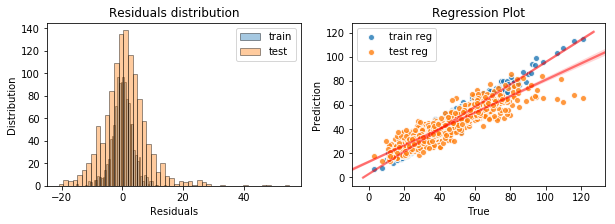

In [26]:
regressor = XGBRegressor(n_jobs=-1, random_state=33)
predictions = eval_model(model=regressor, cv=tscv, X=X_sfm, y=y)
eval_predictions(predictions)

Well, it seems that using XGBoost with recursive feature eliminations performs better than SelectFromModel.

Let's try to optimize some hyperparameters and see the results.

In [38]:
space_xgboost = {
    'max_depth': scope.int(hp.quniform('max_depth', 2, 10, 1)),
    'learning_rate': hp.qloguniform('learning_rate', np.log(1e-4), np.log(10), 1e-4),
    'n_estimators': scope.int(hp.quniform('n_estimators', 30, 1000, 1)),
    'gamma': hp.qloguniform('gamma', np.log(1e-4), np.log(10), 1e-3),
    'reg_alpha': hp.qloguniform('reg_alpha', np.log(1e-4), np.log(10), 1e-3),
    'reg_lambda': hp.qloguniform('reg_lambda', np.log(1e-4), np.log(10), 1e-3)
}

# Objective Function to minimize
def f_objective(p):
    try:
        model = XGBRegressor(n_jobs=-1, random_state=33, **p)
        predictions = eval_model(model=model, cv=tscv, X=X_rfe, y=y)[['true','test_pred']].dropna()
        loss = mean_absolute_error(predictions['true'], predictions['test_pred'])

        return { 'loss': loss, 'status': STATUS_OK }
    except Exception as e:
        #print(f"Error: {e}")
        return { 'loss': np.Inf, 'status': STATUS_FAIL }
    
best = fmin(fn=f_objective,
            space=space_xgboost, 
            algo=tpe.suggest,
            max_evals=100,
            show_progressbar=True,
            trials=Trials())
# best hyperparameters
print("The best hyperparameters:")
print(space_eval(space_xgboost, best))

100%|██████████| 100/100 [06:23<00:00,  4.98s/it, best loss: 4.944221679504078]
The best hyperparameters:
{'gamma': 0.019, 'learning_rate': 0.11170000000000001, 'max_depth': 2, 'n_estimators': 649, 'reg_alpha': 0.001, 'reg_lambda': 0.451}


# Conclusions

We achieved the best result using _MLP_ regression, with a mean absolute error on test data equals to __4.54 €__